In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl

import matplotlib

from utils.train_utils import train_resnet18, load_data, train_conv_nets, load_data
from utils.visualizations import (
    plot_loss_from_file,
    plot_loss_vs_epoch_from_file,
    load_results,
)

from models.conv_nets import make_convNet
from models.resnet import make_resnet18_UniformHe

gpus = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
def count_trainagle_variables(model):
    total_parameters = 0

    for variable in model.trainable_variables:
        local_parameters = 1
        # For each variable count the number of elements it countains.
        shape = variable.get_shape()
        for i in shape:
            local_parameters *= i
        # sum over all the variables.
        total_parameters += local_parameters
    return total_parameters

In [ ]:
depth_3_parameter_counts = []
widths_3 = [i + 1 for i in range(256)]

for k in widths_3:
    model, model_id = make_convNet([32, 32, 3], 3, init_channels=k)
    depth_3_parameter_counts.append(count_trainagle_variables(model))
    
depth_4_parameter_counts = []
widths_4 = [i + 1 for i in range(128)]

for k in widths_4:
    model, model_id = make_convNet([32, 32, 3], 4, init_channels=k)
    depth_4_parameter_counts.append(count_trainagle_variables(model))

depth_5_parameter_counts = []
widths_5 = [i + 1 for i in range(64)]

for k in widths_5:
    model, model_id = make_convNet([32, 32, 3], 5, init_channels=k)
    depth_5_parameter_counts.append(count_trainagle_variables(model))

depth_7_parameter_counts = []
widths_7 = [i + 1 for i in range(16)]

for k in widths_7:
    model, model_id = make_convNet([32, 32, 3], 7, init_channels=k)
    depth_7_parameter_counts.append(count_trainagle_variables(model))

In [58]:
model, model_id = make_convNet([32, 32, 3], 3, init_channels=50)
depth_3_inter_thresh = count_trainagle_variables(model)

model, model_id = make_convNet([32, 32, 3], 5, init_channels=12)
depth_5_inter_thresh = count_trainagle_variables(model)

model, model_id = make_convNet([32, 32, 3], 7, init_channels=3)
depth_7_inter_thresh = count_trainagle_variables(model)

depth_3_inter_thresh, depth_5_inter_thresh, depth_7_inter_thresh

(50810, 56266, 56860)

In [24]:
resnet_widths = [i + 1 for i in range(64)]
resnet_parameter_count = []

for k in resnet_widths:
    model, model_id = make_resnet18_UniformHe([32, 32, 3], k)
    model.build([128, 32, 32, 3])
    resnet_parameter_count.append(count_trainagle_variables(model))

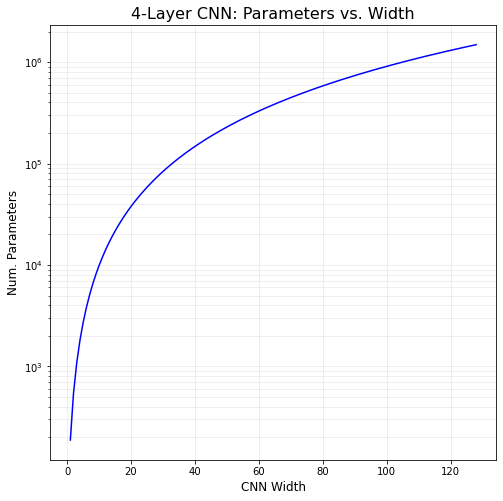

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    
ax.plot(widths_4, depth_4_parameter_counts, c="blue")
ax.set_yscale("log", base=10)
ax.grid(which="both", alpha=0.25)
ax.set_title("4-Layer CNN: Parameters vs. Width", fontsize=16)
ax.set_ylabel("Num. Parameters", fontsize=12)
ax.set_xlabel("CNN Width", fontsize=12)

plt.show()

## Scaling of model size against widthfor CNNs

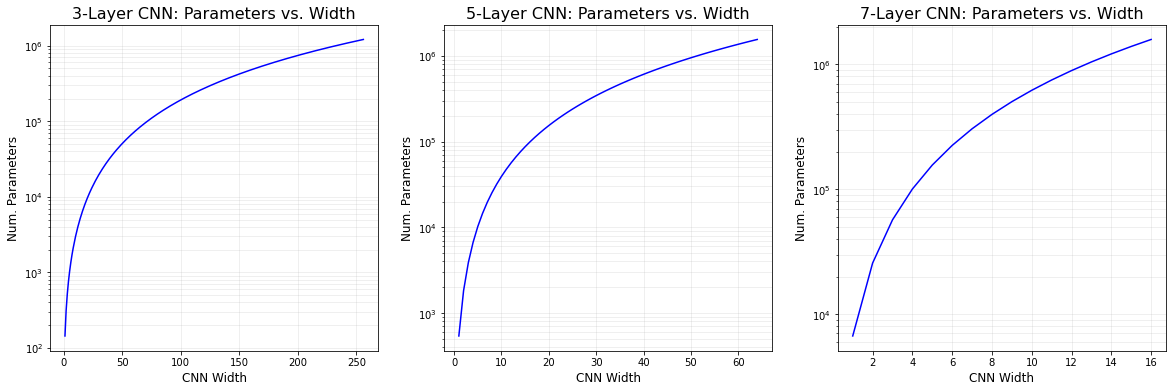

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

d3 = axes[0]
d5 = axes[1]
d7 = axes[2]

d3.plot(widths_3, depth_3_parameter_counts, c="blue")
d3.set_yscale("log", base=10)
d3.grid(which="both", alpha=0.25)
d3.set_title("3-Layer CNN: Parameters vs. Width", fontsize=16)
d3.set_ylabel("Num. Parameters", fontsize=12)
d3.set_xlabel("CNN Width", fontsize=12)

d5.plot(widths_5, depth_5_parameter_counts, c="blue")
d5.set_yscale("log", base=10)
d5.grid(which="both", alpha=0.25)
d5.set_title("5-Layer CNN: Parameters vs. Width", fontsize=16)
d5.set_ylabel("Num. Parameters", fontsize=12)
d5.set_xlabel("CNN Width", fontsize=12)

d7.plot(widths_7, depth_7_parameter_counts, c="blue")
d7.set_yscale("log", base=10)
d7.grid(which="both", alpha=0.25)
d7.set_title("7-Layer CNN: Parameters vs. Width", fontsize=16)
d7.set_ylabel("Num. Parameters", fontsize=12)
d7.set_xlabel("CNN Width", fontsize=12)

plt.show()

## Scaling of model size against widthfor ResNets

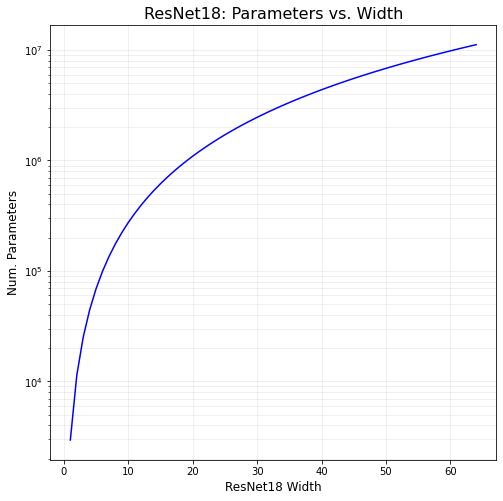

In [26]:
fig, resnet_ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

resnet_ax.plot(resnet_widths, resnet_parameter_count, c="blue")
resnet_ax.set_yscale("log", base=10)
resnet_ax.grid(which="both", alpha=0.25)
resnet_ax.set_title("ResNet18: Parameters vs. Width", fontsize=16)
resnet_ax.set_ylabel("Num. Parameters", fontsize=12)
resnet_ax.set_xlabel("ResNet18 Width", fontsize=12)

plt.show()

## Replicate Figure 5: Test/Train Error at end of training vs Model Width  (Depths 3, 5, & 7)

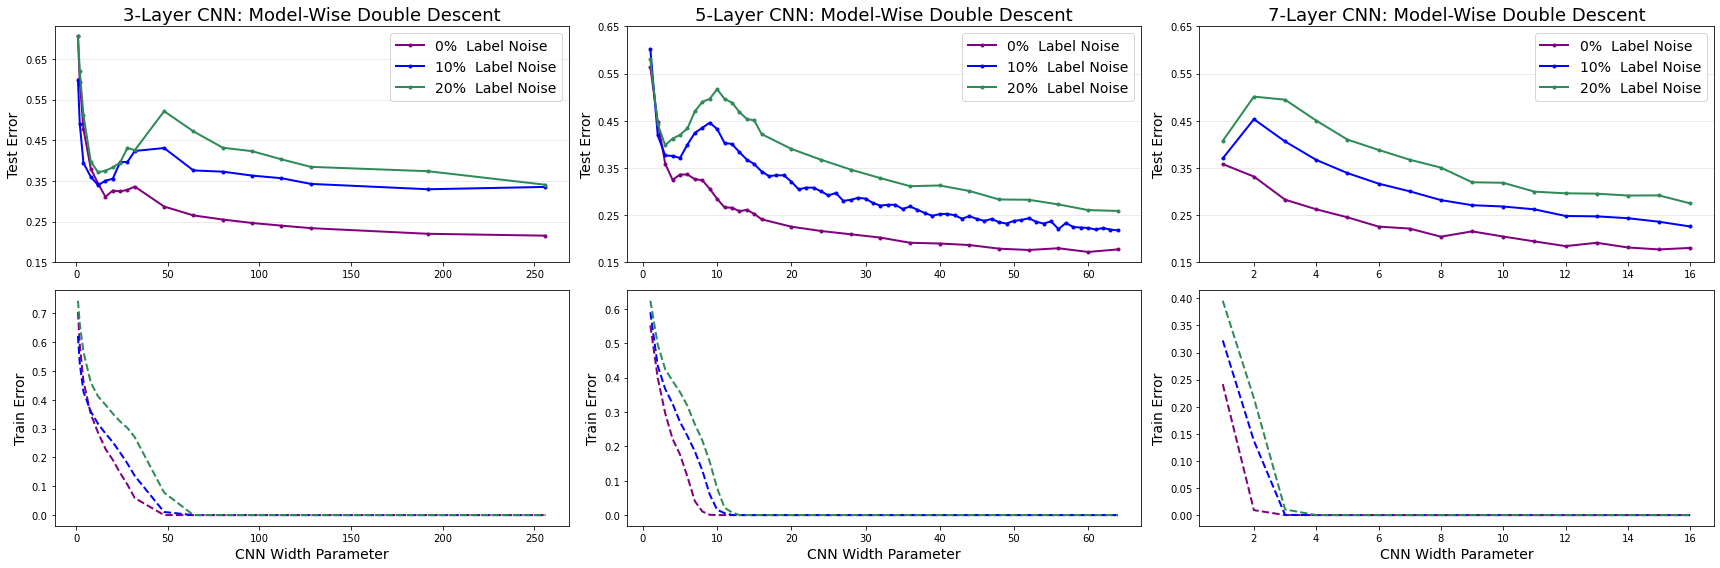

In [45]:
path = "experimental_results_cifar10/"
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 8))

fs_label = 14
fs_title = 18

for axes_idx, depth in enumerate([3, 5, 7]):
    results_0 = load_results(path + f"conv_nets_depth_{depth}_0pct_noise.pkl")
    results_10 = load_results(path + f"conv_nets_depth_{depth}_10pct_noise.pkl")
    results_20 = load_results(path + f"conv_nets_depth_{depth}_20pct_noise.pkl")

    train_0 = results_0.get("accuracy")
    train_10 = results_10.get("accuracy")
    train_20 = results_20.get("accuracy")

    test_0 = results_0.get("val_accuracy")
    test_10 = results_10.get("val_accuracy")
    test_20 = results_20.get("val_accuracy")

    test_plt = axes[0][axes_idx]
    train_plt = axes[1][axes_idx]

    test_plt.set_title(
        f"{depth}-Layer CNN: Model-Wise Double Descent", fontsize=fs_title
    )

    test_plt.plot(
        results_0["widths"],
        (1 - test_0[:, -1]),
        label="0%  Label Noise",
        c="purple",
        lw=2,
        marker="o",
        ms=3,
    )
    test_plt.plot(
        results_10["widths"],
        (1 - test_10[:, -1]),
        label="10%  Label Noise",
        c="blue",
        lw=2,
        marker="o",
        ms=3,
    )
    test_plt.plot(
        results_20["widths"],
        (1 - test_20[:, -1]),
        label="20%  Label Noise",
        c="seagreen",
        lw=2,
        marker="o",
        ms=3,
    )
    test_plt.legend(fontsize=14)
    test_plt.set_ylabel("Test Error", fontsize=fs_label)

    train_plt.plot(results_0["widths"], (1 - train_0)[:, -1], c="purple", lw=2, ls="--")
    train_plt.plot(results_10["widths"], (1 - train_10)[:, -1], c="blue", lw=2, ls="--")
    train_plt.plot(
        results_20["widths"], (1 - train_20)[:, -1], c="seagreen", lw=2, ls="--"
    )
    train_plt.set_xlabel("CNN Width Parameter", fontsize=fs_label)
    train_plt.set_ylabel("Train Error", fontsize=fs_label)
    
    test_plt.grid(alpha=0.3, axis='y')
    test_plt.set_yticks([0.15 + i*0.1 for i in range(6)])
    

fig.tight_layout()
plt.show()

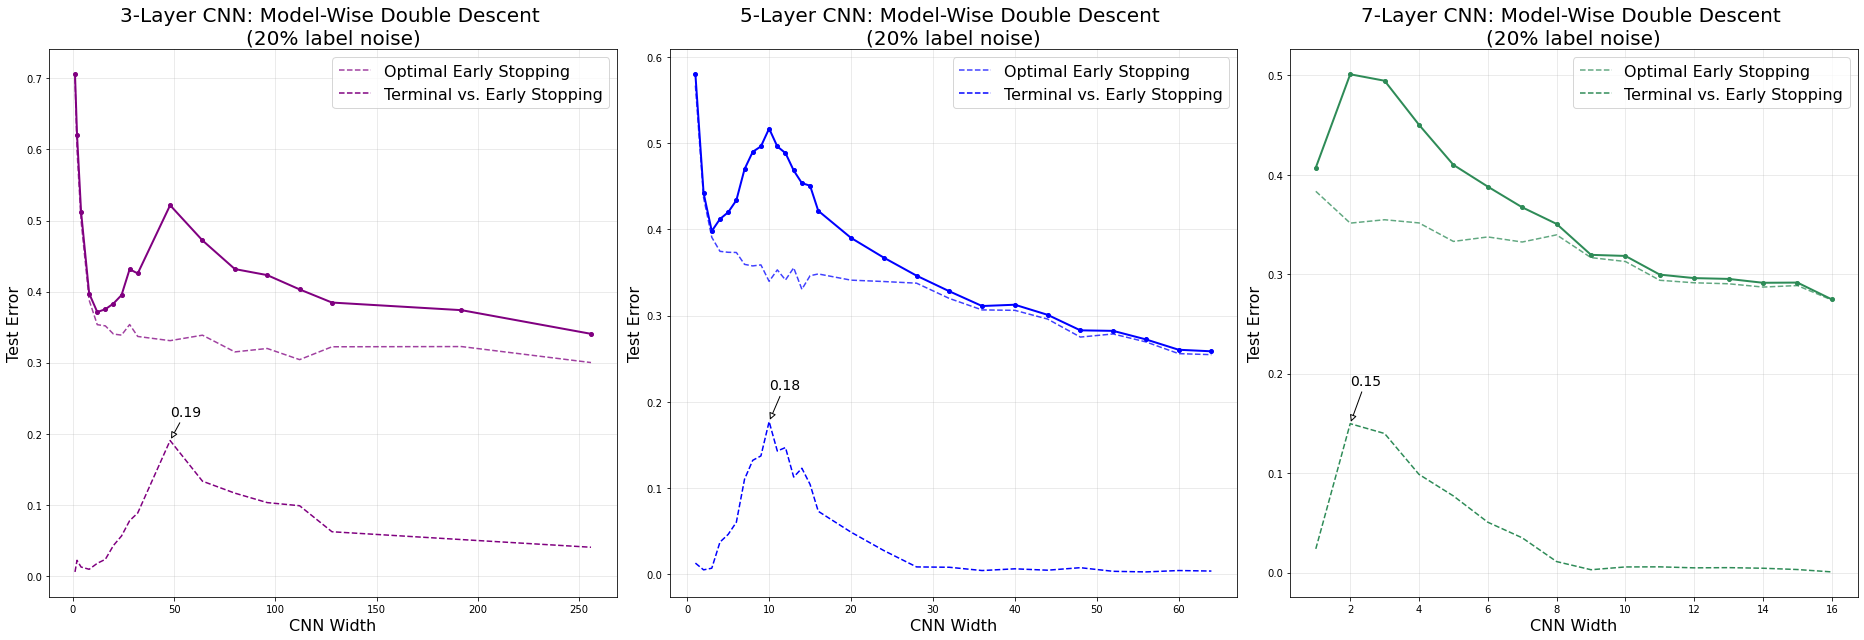

In [15]:
path = "experimental_results_cifar10/"

def plot_early_stopping_gap(
    noise, 
    fs_label=14,
    fs_legend=12,
    fs_title=18,
    fs_annotate=11
):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(26, 9))

    d3 = axes[0]
    d5 = axes[1]
    d7 = axes[2]

    results_3 = load_results(path + f"conv_nets_depth_3_{noise}pct_noise.pkl")
    results_5 = load_results(path + f"conv_nets_depth_5_{noise}pct_noise.pkl")
    results_7 = load_results(path + f"conv_nets_depth_7_{noise}pct_noise.pkl")
    results = [results_3, results_5, results_7]

    test_3 = 1 - results_3.get("val_accuracy")
    test_5 = 1 - results_5.get("val_accuracy")
    test_7 = 1 - results_7.get("val_accuracy")
    test = [test_3, test_5, test_7]

    colors = ['purple', 'blue', 'seagreen']
    depths = [3, 5, 7]

    for color, depth, data, res, ax in zip(colors, depths, test, results, axes):
        res["widths"]
        data[:, -1]
        ax.plot(res["widths"], data[:, -1], c=color, lw=2, marker="o", ms=4)
        ax.plot(
            res["widths"],
            data.min(axis=1),
            c=color,
            alpha=0.75,
            ls="--",
            label="Optimal Early Stopping",
        )
        ax.plot(
            res["widths"], 
            data[:, -1]-data.min(axis=1),
            c=color,
            ls="--",
            label="Terminal vs. Early Stopping",
        )
        
        peak_diff = (data[:, -1]-data.min(axis=1)).max()
        peak_diff_width = res["widths"][(data[:, -1]-data.min(axis=1)).argmax()]
        ax.annotate(
            f'{peak_diff:.2f}',
            xy=(peak_diff_width, peak_diff), 
            xytext=(peak_diff_width, peak_diff + 0.05),
            va="top", 
            ha="left",
            fontsize=fs_annotate,
            arrowprops=dict(arrowstyle="-|>", fc="w"))
        
        ax.set_title(f"{depth}-Layer CNN: Model-Wise Double Descent \n({noise}% label noise)", fontsize=fs_title)
        ax.set_xlabel("CNN Width", fontsize=fs_label)
        ax.set_ylabel("Test Error", fontsize=fs_label)

        ax.legend(fontsize=fs_legend)
        ax.grid(alpha=0.3)

    fig.tight_layout()
    plt.show()
    

plot_early_stopping_gap(20, 16, 16, 20, 14)

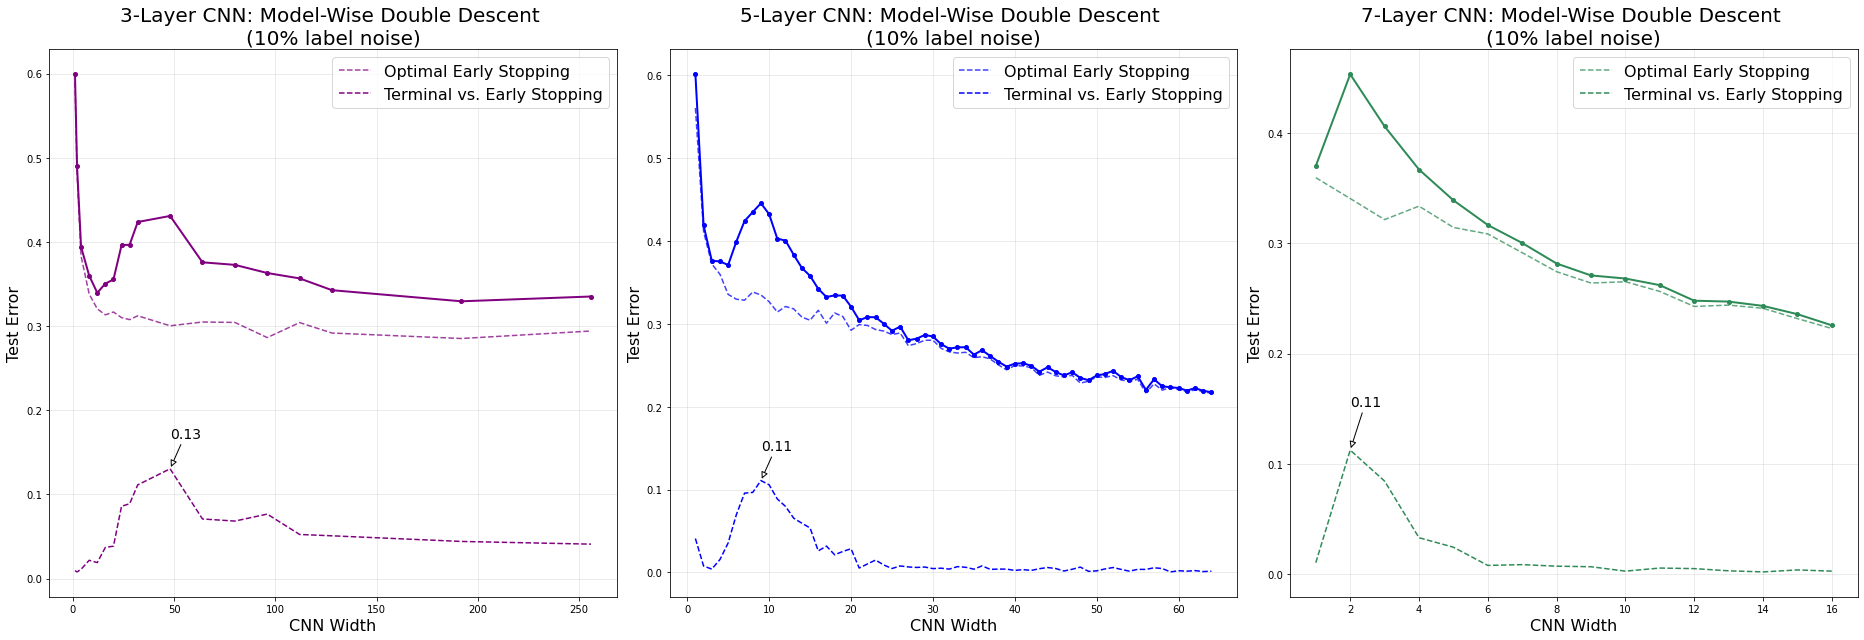

In [16]:
plot_early_stopping_gap(10, 16, 16, 20, 14)

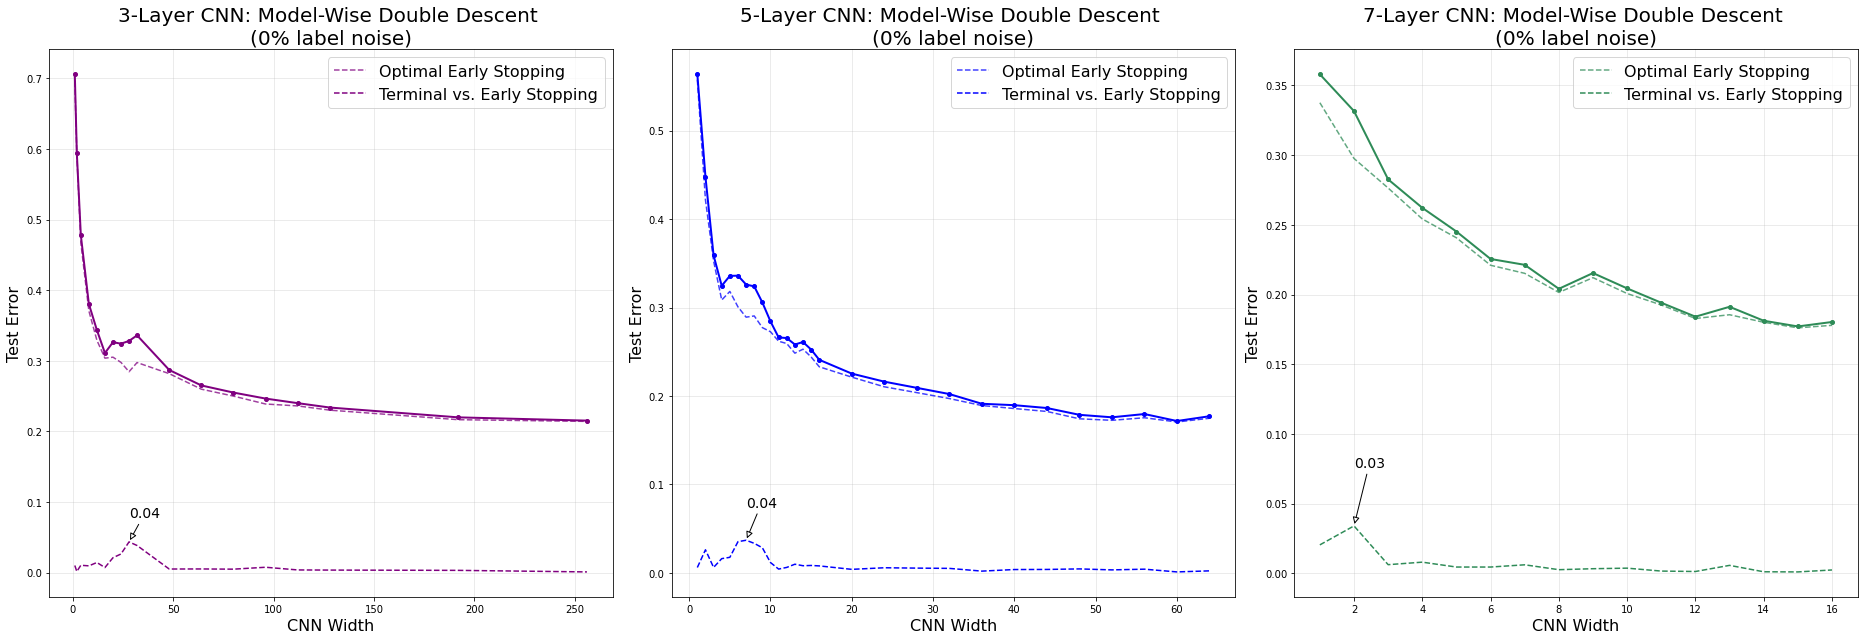

In [17]:
plot_early_stopping_gap(0, 16, 16, 20, 14)

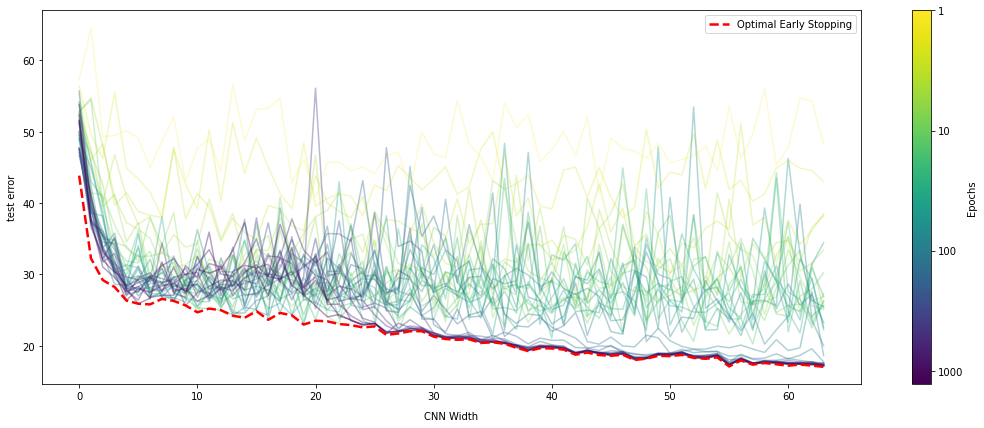

In [18]:
depth = 5
path = "experimental_results_cifar10/"
results_10 = load_results(path + f"conv_nets_depth_{depth}_10pct_noise.pkl")
base = 1.2
p = 0.25


def rescale_cmap(name, rescale):
    cmap = plt.cm.get_cmap(name)
    colors = []
    for i in range(256):
        x = i / 256
        colors += [cmap(rescale(x))]
    return matplotlib.colors.ListedColormap(colors)


def scale(maxIdx, i):
    return np.log(i) / np.log(maxIdx)


test_acc = 100 * (1 - results_10.get("val_accuracy"))
test_acc = 1.0 - (1 - p) * (1 - test_acc) + test_acc * p / 9.0  # noisy test


maxIdx = test_acc.shape[1]
idx = np.unique(
    np.array(base ** np.arange(0, np.log(maxIdx) / np.log(base)), dtype=int)
)

fig, ax1 = plt.subplots(1, 1, figsize=(15, 6), sharex=True)

# cos: skews more colors to the middle of the range
# x**a: skews more colors towards the beginning/end of the range for larger/smaller a
# p cos(...) + q x: controls strength of rescaling
cmap = rescale_cmap(
    "viridis", lambda x: 0.5 * (1 - np.cos(np.pi * x ** 0.7)) / 2 + 0.5 * x
)
for i, j in enumerate(idx):
    # s = j / len(idx)
    s = scale(maxIdx, j)

    alpha = min(0.2 * np.sqrt(s) + 0.2, 1)
    if s == 1.0:
        alpha = 1.0
    ax1.plot(test_acc[:, i], linestyle="-", color=cmap(1.0 - s), alpha=alpha)

ax1.plot(
    test_acc.min(axis=1),
    linestyle="dashed",
    color="red",
    lw=2.5,
    label="Optimal Early Stopping",
)

ax1.set_ylabel("test error")
ax1.set_xlabel("CNN Width")
ax1.xaxis.labelpad = 10
ax1.yaxis.labelpad = 5

ax1.legend()
plt.tight_layout()

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])

ticks = 1 - scale(maxIdx, [1, 10, 100, 1000])
# print(ticks)

cb = plt.colorbar(sm, ticks=ticks)
cb.ax.set_yticklabels(["1", "10", "100", "1000"])
cb.set_label("Epochs")

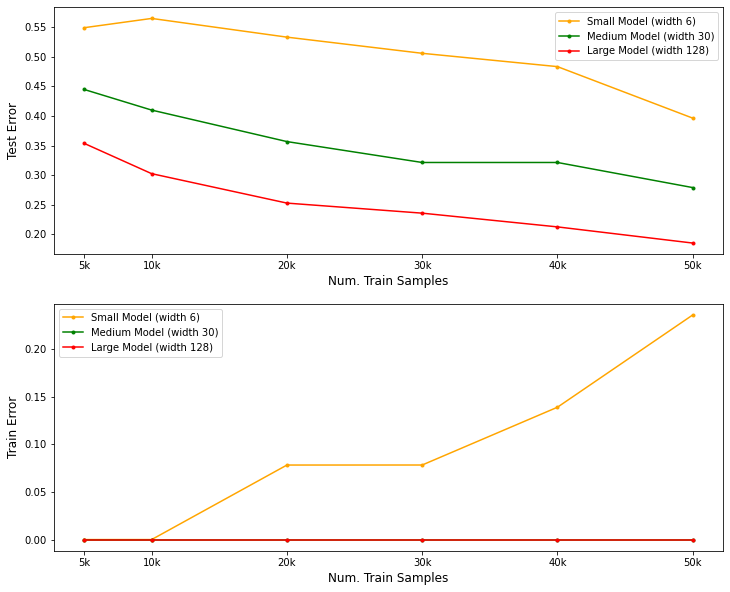

In [39]:
fs_label = 12

path = "subsample_results/width_6.pkl"
results = load_results(path)
width_6_test = 1 - results.get("val_accuracy")
width_6_train = 1 - results.get("accuracy")

path = "subsample_results/width_30.pkl"
results = load_results(path)
width_30_test = 1 - results.get("val_accuracy")
width_30_train = 1 - results.get("accuracy")

path = "subsample_results/width_128.pkl"
results = load_results(path)
width_128_test = 1 - results.get("val_accuracy")
width_128_train = 1 - results.get("accuracy")

sample_sizes = results['widths']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

test_plt, train_plt =ax[0], ax[1]

test_plt.plot(sample_sizes, width_6_test[:, -1], c='orange', ms=3, marker='o', label='Small Model (width 6)')
test_plt.plot(sample_sizes, width_30_test[:, -1], c='green', ms=3, marker='o', label='Medium Model (width 30)')
test_plt.plot(sample_sizes, width_128_test[:, -1], c='red', ms=3, marker='o', label='Large Model (width 128)')

train_plt.plot(sample_sizes, width_6_train[:, -1], c='orange', ms=3, marker='o', label='Small Model (width 6)')
train_plt.plot(sample_sizes, width_30_train[:, -1], c='green', ms=3, marker='o', label='Medium Model (width 30)')
train_plt.plot(sample_sizes, width_128_train[:, -1], c='red', ms=3, marker='o', label='Large Model (width 128)')

test_plt.set_xlabel('Num. Train Samples', fontsize=fs_label)
train_plt.set_xlabel('Num. Train Samples', fontsize=fs_label)

test_plt.set_xticks(sample_sizes)
train_plt.set_xticks(sample_sizes)

test_plt.set_xticklabels([f'{n // 1000}k' for n in sample_sizes])
train_plt.set_xticklabels([f'{n // 1000}k' for n in sample_sizes])

test_plt.set_ylabel('Test Error', fontsize=fs_label)
train_plt.set_ylabel('Train Error', fontsize=fs_label)

test_plt.legend()
train_plt.legend()

plt.show()

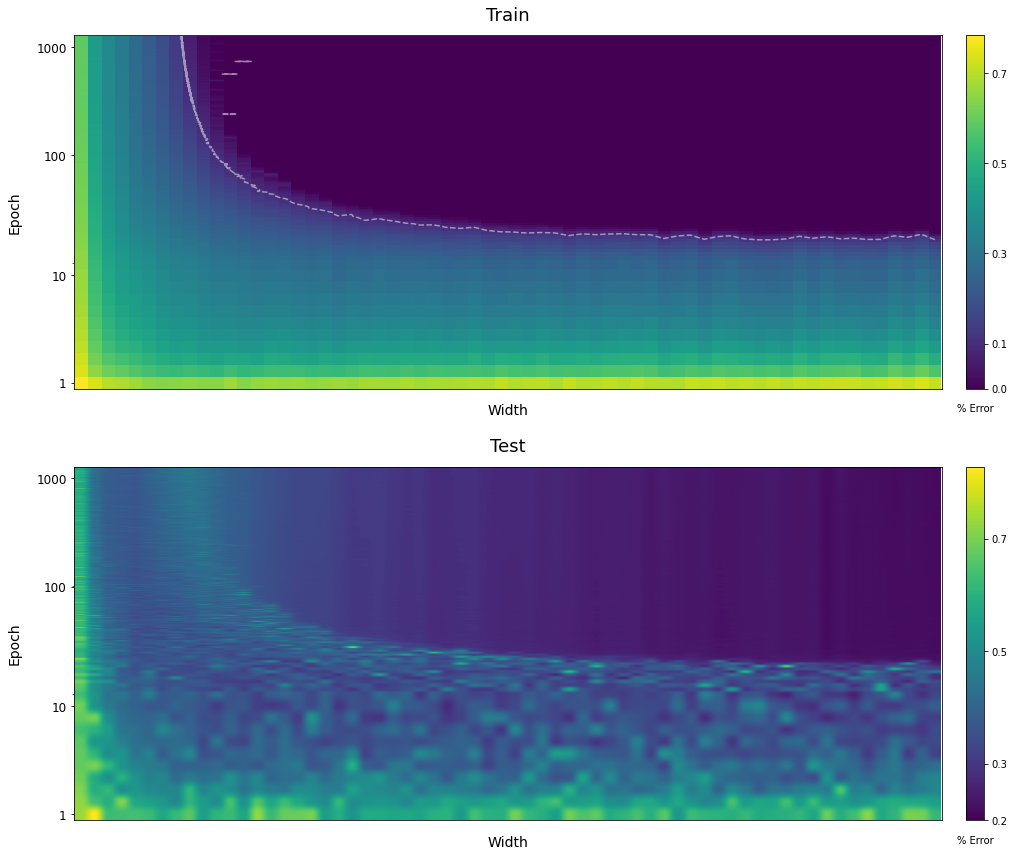

In [29]:
path = "experimental_results_cifar10/"
plot_loss_vs_epoch_from_file(path + f"conv_nets_depth_5_10pct_noise_alpha_1.pkl", [])

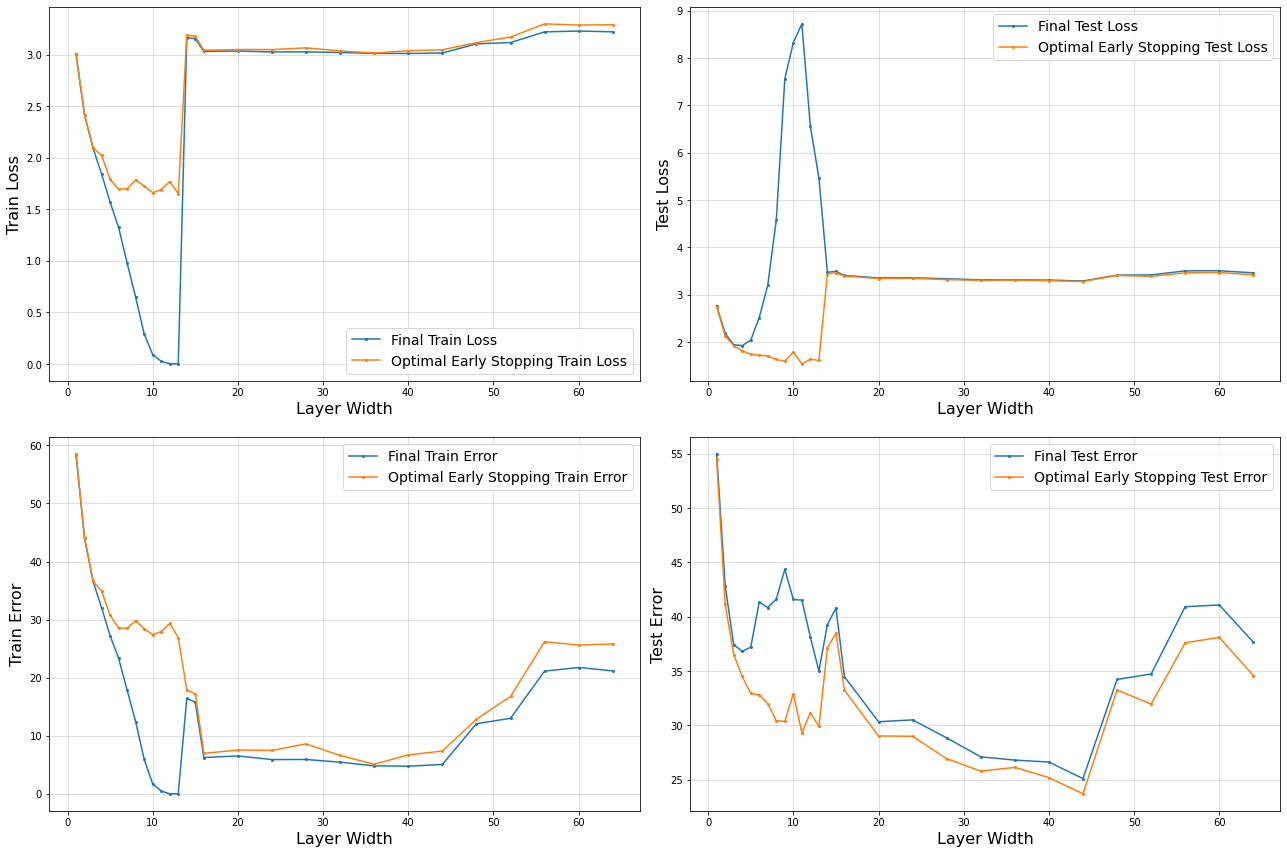

In [102]:
path = "experimental_results_cifar10/"
plot_loss_from_file("experimental_results_cifar10/conv_nets_depth_5_10pct_noise_alpha_0_75.pkl")